In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "light cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)

import ssm
from ssm.util import random_rotation, find_permutation

In [2]:
# Set the parameters of the SLDS
T = 1000    # number of time bins
K = 5       # number of discrete states
D = 2       # number of latent dimensions
N = 10      # number of observed dimensions

In [3]:
# Make an SLDS with the true parameters
true_slds = ssm.SLDS(N, K, D, emissions="gaussian_orthog")
for k in range(K):
    true_slds.dynamics.As[k] = .95 * random_rotation(D, theta=(k+1) * np.pi/20)
z, x, y = true_slds.sample(T)

# Mask off some data
mask = npr.rand(T, N) < 0.9
y_masked = y * mask

# Variational Laplace-EM

We will fit a switching linear dynamical system (SLDS) to the observed data $y$. Our approach combines variational inference and a Laplace approximation. The objective we maximize is the evidence lower bound (ELBO)

$$ \mathcal{L}_q(\theta) = \mathbb{E}_{q(z) q(x)}[\log p(z,x,y|\theta)] - \mathbb{E}_{q(z)}[\log q(z)] - \mathbb{E}_{q(x)}[\log q(x)] $$

where $\theta$ are the model parameters, $z$ are the discrete latent variables, and $x$ are the continuous latent variables. We introduced an approximate posterior that factorizes over the discrete and continuous latent variables, $p(z, x \, | \, \theta, y) \approx q(z) \, q(x)$. This form of the posterior corresponds to the `variational_posterior="structured_meanfield"` argument in the `fit` method.

The variational Laplace-EM inference method performs three updates at each iteration:
1. Update $q(z)$ using the optimal coordinate ascent variational inference update
2. Update $q(x)$ using a Laplace approximation at the most likely latent path (note that this step is not guaranteed to increase the ELBO)
3. Update $\theta$ by optimizing the ELBO with respect to the model parameters

You can initialize a variational posterior and fit the model by running the function
```
# Fit the model using Laplace-EM with a structured variational posterior
elbos, q_lem = slds.fit(data, inputs, masks, method="laplace_em",
                        variational_posterior="structured_meanfield",
                        initialize=False, num_iters=100)
```
The output variables are the values of the objective at each iteration `elbos` and the variational posterior object `q_lem`. If you have already initialized a variational posterior object, you can pass that object as the argument of the `variational_posterior` parameter instead. Here, the `initialize` parameter was set to `False`, which assumes we have already initialized the model. Additionally, note that in `fit` you can also pass in keyword arguments for initialization of the variational posterior. 

### Hyperparameters
There are a number of hyperparameters that can be used when fitting with `laplace_em`. These include generic hyperparameters:
- `num_iters` - the number of iterations to run (default = 100)
- `learning` - optimize the model parameters when True (default = True)
    
Discrete state hyperparameters:
- `num_samples` - number of Monte Carlo samples (default = 1) used for evaluating expectations with respect to $q(x)$ in the update for $q(z)$

Continuous state hyperparameters:
- `continuous_optimizer`, `continuous_tolerance`, `continuous_maxiter` specify parameters of the optimization for finding the most likely latent path in the continuous latent update. We recommend using the default optimizer Newton's method (`newton`) to compute the most likely latent path. However, Hessian-free optimization is supported with `lbfgs`. The tolerance and maxiter parameters can be adjusted for the user's requirements. 

Model parameter update hyperparameters:
- `alpha` - parameter in $[0,1)$ with default $0.5$ that determines how greedy we are in updating the model parameters at each iteration. This is only used in conjunction with `parameters_update="mstep"`. 
- `parameters_update` - the model parameter updates are implemented via an m-step given a single sample from $q(x)$ (default, `"mstep"`) or whether using SGD with samples from $q(x)$ (`"sgd"`).
- `emission_optimizer` - the optimizer used to update parameters in the m-step. This defaults to the `adam` optimizer when using the `"sgd"` parameter updates. 
- `emission_optimizer_maxiter` - the maximum number of iterations for the inner loop of optimizing the emissions parameters. 

### Exploring the effect of the `alpha` hyperparameter

In the `"mstep"` parameters update, we optimize the joint log-likelihood conditioned on a single sample from $q(x)$ to get a point estimate of the parameters $\theta^\star$. The new parameters at iteration $t$ are then given by

$$ \theta^{(t)} = (1 - \alpha) \, \theta^\star + \alpha \, \theta^{(t-1)}. $$

If `alpha=0.0` we set the parameters to $\theta^\star$, whereas for nonzero `alpha` the parameters are partially updated towards $\theta^\star$. The default is `alpha=0.5`. We have found that performance varies for different values of `alpha` and that the performance can depend on the specific problem. We will demonstrate below how `alpha` can affect inference by sweeping over five different values of `alpha` in model fits below.

In [4]:
alphas = [0.0, 0.25, 0.5, 0.75, 0.9]
results = {}
for alpha in alphas:
    print("Fitting SLDS with Laplace-EM, alpha = {}".format(alpha))

    # Create the model and initialize its parameters
    slds = ssm.SLDS(N, K, D, emissions="gaussian_orthog")
    slds.initialize(y_masked, masks=mask)

    # Fit the model using Laplace-EM with a structured variational posterior
    q_lem_elbos, q_lem = slds.fit(y_masked, masks=mask, method="laplace_em",
                               variational_posterior="structured_meanfield",
                               initialize=False, num_iters=100, alpha=alpha)

    # Get the posterior mean of the continuous states
    q_lem_x = q_lem.mean_continuous_states[0]

    # Find the permutation that matches the true and inferred states
    slds.permute(find_permutation(z, slds.most_likely_states(q_lem_x, y)))
    q_lem_z = slds.most_likely_states(q_lem_x, y)

    # Smooth the data under the variational posterior
    q_lem_y = slds.smooth(q_lem_x, y)

    results[(alpha)] = (slds, q_lem, q_lem_elbos, q_lem_x, q_lem_z, q_lem_y)

Fitting SLDS with Laplace-EM, alpha = 0.0
Initializing with an ARHMM using 25 steps of EM.



Fitting SLDS with Laplace-EM, alpha = 0.25
Initializing with an ARHMM using 25 steps of EM.



Fitting SLDS with Laplace-EM, alpha = 0.5
Initializing with an ARHMM using 25 steps of EM.



Fitting SLDS with Laplace-EM, alpha = 0.75
Initializing with an ARHMM using 25 steps of EM.



Fitting SLDS with Laplace-EM, alpha = 0.9
Initializing with an ARHMM using 25 steps of EM.


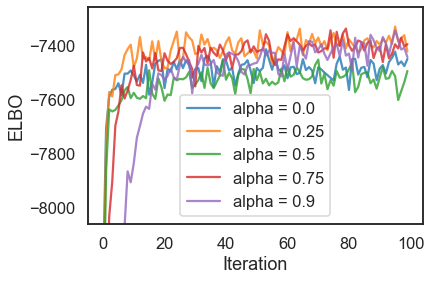

In [5]:
# Plot the ELBOs
q_elbos = []
for alpha in alphas:
    _,_,q_lem_elbos,_,_,_ = results[(alpha)]
    q_elbos += [q_lem_elbos]
    plt.plot(q_lem_elbos[1:], label="alpha = {}".format(alpha), alpha=0.8)
plt.xlabel("Iteration")
plt.ylabel("ELBO")
q_max = np.array(q_elbos).max()
plt.ylim([q_max-0.1*np.abs(q_max),q_max+0.01*np.abs(q_max)])
plt.legend()

(0.0, 1000.0)

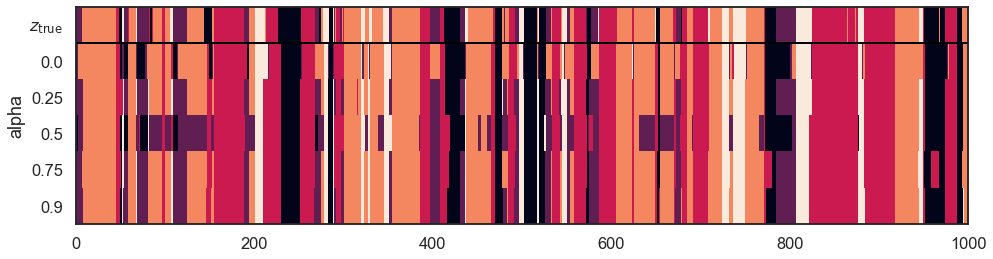

In [7]:
# Plot the true and inferred states
xlim = (0, 1000)

zs = []
for alpha in alphas:
    (_, _, _, _, q_lem_z, _) = results[(alpha)]
    zs += [q_lem_z]
    
plt.figure(figsize=(16,4))
plt.imshow(np.row_stack((z, zs)), aspect="auto", interpolation="none")
plt.plot(xlim, [0.5, 0.5], '-k', lw=2)
plt.yticks([0,1,2,3,4,5],["$z_{\\mathrm{true}}$", *alphas])
plt.ylabel("alpha")
plt.xlim(xlim)

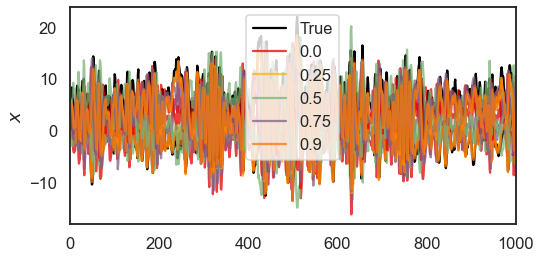

In [8]:
plt.figure(figsize=(8,4))
for d in range(D):
    plt.plot(x[:,d] + 4 * d, '-', color='k', label="True" if d==0 else None)
    for i, alpha in enumerate(alphas):
        _,_,_,q_lem_x,_,_ = results[(alpha)]
        plt.plot(q_lem_x[:,d] + 4 * d, '-',  color=colors[i+1], label=alpha if d == 0 else None, alpha=0.75)
plt.ylabel("$x$")
plt.xlim(xlim)
plt.legend()

(0.0, 1000.0)

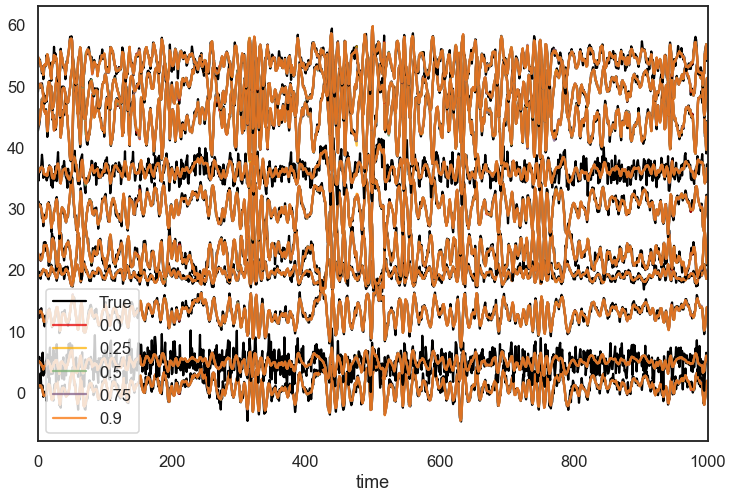

In [11]:
# Plot the smoothed observations
plt.figure(figsize=(12,8))
for n in range(N):
    plt.plot(y[:, n] + 6 * n, '-', color='k', label="True" if n == 0 else None)
    for i, alpha in enumerate(alphas):
        _,_,_,_,_,q_lem_y = results[(alpha)]
        plt.plot(q_lem_y[:,n] + 6 * n, '-',  color=colors[i+1], label=alpha if n == 0 else None, alpha=0.75)
plt.legend()
plt.xlabel("time")
plt.xlim(xlim)